In [64]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
# 创建模型
model = pybamm.BaseModel()


# 定义变量和参数
c = pybamm.Variable("Electrolyte concentration", domain=["separator"])
phi = pybamm.Variable("Electrode potential", domain=["separator"])
phi_e = pybamm.Variable("Electrolyte potential", domain=["separator"])
c_k = pybamm.Variable("Li+ concentration in electrode", domain=["separator"])

#c_av = pybamm.Variable("X-averaged electrolyte concentration", domain=["separator"])



U = pybamm.Scalar(0)
j_k = pybamm.Scalar(1)
j_e = pybamm.Scalar(1)
 
D_e = pybamm.Scalar(1e-10)
D_li = pybamm.Scalar(5e-10)
sigma_k = pybamm.Scalar(1)
kappa = pybamm.Scalar(1)
A = pybamm.Scalar(1)
 
 
# Electrolyte mass transport
N = -D_e * pybamm.grad(c) 
dcdt = - pybamm.div(N)
model.rhs = {c: dcdt}
 
# Li+ concentration in electrode transport
N_c_k = -D_li * pybamm.grad(c_k)
dc_k_dt = -pybamm.div(N_c_k)
model.rhs[c_k] = dc_k_dt
#reaction_rate = j_k - j_e  
 
# Electrode charge transport
i_k = -sigma_k * pybamm.grad(phi)
i_e = -kappa * pybamm.grad(phi_e)
model.algebraic = {
    phi: pybamm.div(i_k) + A * j_k,
    phi_e: pybamm.div(i_e) - A * j_e
}
 
# Overpotential (as an auxiliary variable)
eta_k = phi - phi_e - U

c_av = pybamm.x_average(c)


model.variables = {
    "Electrode potential": phi,
    "Electrolyte potential": phi_e,
    "Overpotential": eta_k,
    "Electrolyte concentration": c,
    "Li+ concentration in electrode":c_k,
    "X-averaged electrolyte concentration": pybamm.x_average(c)
    
}
 
# 定义初始条件
model.initial_conditions = {
    c: pybamm.Scalar(1),
    phi: pybamm.Scalar(0),
    phi_e: pybamm.Scalar(0),
    c_k: pybamm.Scalar(1),
}
 
# 定义外加电流
I_app = -10e-6
A = 8e-3 * 1e-3  
 
current_density = I_app / A
 
 
# 定义边界条件
model.boundary_conditions = {
    c: {"left": (pybamm.Scalar(1), "Dirichlet"), "right": (pybamm.Scalar(0), "Neumann")},
    phi: {"left": (pybamm.Scalar(0), "Dirichlet"), "right": (pybamm.Scalar(current_density), "Neumann")},
    phi_e: {"left": (pybamm.Scalar(0), "Dirichlet"), "right": (pybamm.Scalar(0), "Dirichlet")},
    c_k: {"left": (pybamm.Scalar(1), "Dirichlet"), "right": (pybamm.Scalar(0), "Neumann")}
}
 
 
  
x_s = pybamm.SpatialVariable("x_s", domain=["separator"], coord_sys="cartesian")
geometry = {
    "separator": {x_s: {"min": pybamm.Scalar(8.52e-5), "max": pybamm.Scalar(9.72e-5)}},
}
 
 
submesh_types = {
    "separator": pybamm.MeshGenerator(pybamm.Uniform1DSubMesh),
}
var_pts = {x_s: 20}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
spatial_methods = {
    "separator": pybamm.FiniteVolume(),
}

disc = pybamm.Discretisation(mesh, spatial_methods)
 
 
disc.process_model(model)
 
# 检查模型
print(model)
 
 
 
# 创建仿真器并运行仿真，使用CasadiSolver
sim = pybamm.Simulation(model, solver=pybamm.CasadiSolver())
t = [0, 7200]
solution = sim.solve(t)  # 例如运行2小时
 
 
 
pybamm.dynamic_plot(
    solution,
    [
        "Electrode potential",
        "Electrolyte potential",
        "Overpotential",
        "Electrolyte concentration",
        "Li+ concentration in electrode"
    ],
 
)

interactive(children=(FloatSlider(value=0.0, description='t', max=2.0, step=0.02), Output()), _dom_classes=('w…

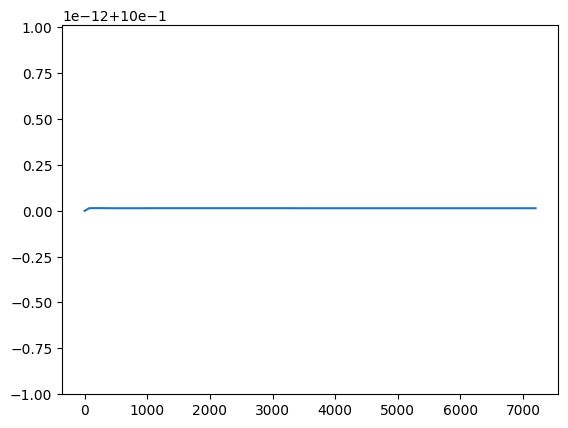

In [68]:
plt.plot(solution.t,solution['X-averaged electrolyte concentration'].entries)